<a href="https://colab.research.google.com/github/sjnaj/DeepLearning/blob/master/Convolution/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VGG

经典卷积神经网络的基本组成部分是下面的这个序列：

- 带填充以保持分辨率的卷积层；

- 非线性激活函数，如ReLU；

- 汇聚层，如最大汇聚层。

而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层

在最初的VGG论文中，作者使用了带有卷积核、填充为1（保持高度和宽度）的卷积层，和带有汇聚窗口、步幅为2（每个块后的分辨率减半）的最大汇聚层

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


<img src="http://d2l.ai/_images/vgg.svg">

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs,in_channels,out_channels):
  layers=[]
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
    layers.append(nn.ReLU())
    in_channels=out_channels#第一个卷积层将输入通道数为输出通道数，其余的都等于输出通道数
  layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
  return nn.Sequential(*layers)



原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。
第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

In [1]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [8]:
def vgg(conv_arch):
  conv_blks=[]
  in_channels=1#初始通道数
  #卷积层部分
  for (num_convs,out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
    in_channels=out_channels
  return nn.Sequential(
      *conv_blks,

      #全连接部分
      nn.Flatten(),
      nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,10)
      
  )

In [9]:
net=vgg(conv_arch)

In [10]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


[**由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络**]，足够用于训练Fashion-MNIST数据集。

In [12]:
radio=4
small_conv_arch=[(pair[0],pair[1]//radio) for pair in conv_arch]
net=vgg(small_conv_arch)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


training on cpu


KeyboardInterrupt: ignored

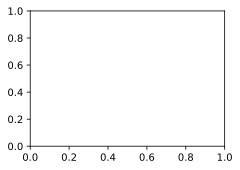

In [13]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())